# Adaptive Distances

In this example, we show how and when to use the adaptive distances feature of pyabc. "Adaptive distances" means that the distance function is not pre-defined (e.g. after pre-processing), but evolves over time during the ABC run, depending on the observed summary statistics. This can be useful if different summary statistics vary on different scales, but it is not immediately clear how to weight them. For this case, in adaptive distances weights are adjusted in each iteration so as to balance the impact of all summary statistics on the computed distance. 

Currently, adaptively weighted p-norm distances (e.g. Euclidean) are implemented in pyABC, but it is easily possible to define arbitrary adaptive distances.

For illustration, we consider a simple Gaussian model:

In [1]:
import scipy
import tempfile
import os
import matplotlib.pyplot as pyplot
import pyabc.visualization
import logging


# for debugging
df_logger = logging.getLogger('Distance')
df_logger.setLevel(logging.DEBUG)

# model definition
def model(p):
    return {'ss1': p['theta'] + 1 + 0.1 * scipy.randn(),
            'ss2': 2 + 10 * scipy.randn()}

# true model parameter
theta_true = 3

# observed summary statistics
observation = {'ss1': theta_true + 1, 'ss2': 2}

# prior distribution
prior = pyabc.Distribution(theta=pyabc.RV('uniform', 0, 10))

# database
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")

/home/yannik/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


Summary statistic ss2 has a high variance compared to summary statistic ss1. In addition, ss1 is informative about the model parameters $\theta$, ss2 not. We expect that the proposal distribution for $\theta$ iteratively centers around the true value $\theta=3$. Thus, the variability for the sampled ss1 decreases iteratively, while the variability of the sampled ss2 stays approximately constant. If both summary statistics are weighted similarly in the calculation of the distance between sample and observation, there is hence an undesirable high impact of ss2, so that convergence can be slowed down. In contrast, if we weight ss1 higher, we may hope that our estimation of $\theta$ is improved.

These informal expectations being stated, let us continue with the implementation. First, we consider a non-adaptive Euclidean distance:

In [2]:
distance = pyabc.PNormDistance(p=2)

abc = pyabc.ABCSMC(model, prior, distance)

abc.new(db_path, observation)

history0 = abc.run(minimum_epsilon=.1, max_nr_populations=8)

INFO:History:Start <ABCSMC(id=39, start_time=2019-09-28 19:41:56.318530, end_time=None)>
INFO:Epsilon:initial epsilon is 9.390007180893171
INFO:ABC:t:0 eps:9.390007180893171
INFO:ABC:t:1 eps:5.050334211985945
INFO:ABC:t:2 eps:3.108214034350902
INFO:ABC:t:3 eps:2.19511176411861
INFO:ABC:t:4 eps:1.5236607940536784
INFO:ABC:t:5 eps:1.0834841029888673
INFO:ABC:t:6 eps:0.7723430420059322
INFO:ABC:t:7 eps:0.5532845038714075
INFO:History:Done <ABCSMC(id=39, start_time=2019-09-28 19:41:56.318530, end_time=2019-09-28 19:42:10.302570)>


Let us visualize the results for the non-adaptive distance:

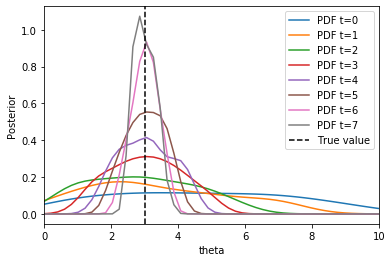

In [3]:
# plotting

def plot(history):
    fig, ax = pyplot.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=10,
                                       x='theta', ax=ax,
                                       label="PDF t={}".format(t))
    ax.axvline(theta_true, color='k', linestyle='dashed', label="True value")
    ax.legend()


plot(history0)

Second, we consider an adaptive Euclidean distance:

In [4]:
distance_adaptive = pyabc.AdaptivePNormDistance(p=2)

abc = pyabc.ABCSMC(
    model, prior, distance_adaptive,
    acceptor = pyabc.acceptor.accept_use_complete_history)

abc.new(db_path, observation)

history1 = abc.run(minimum_epsilon=.1, max_nr_populations=8)

INFO:History:Start <ABCSMC(id=40, start_time=2019-09-28 19:42:10.780389, end_time=None)>
DEBUG:Distance:updated weights[0] = {'ss1': 1.5705258655526095, 'ss2': 0.4294741344473906}
INFO:Epsilon:initial epsilon is 6.580200314378885
INFO:ABC:t:0 eps:6.580200314378885
DEBUG:Distance:updated weights[1] = {'ss1': 1.5389948562623306, 'ss2': 0.4610051437376694}
INFO:ABC:t:1 eps:4.274919255165815
DEBUG:Distance:updated weights[2] = {'ss1': 1.6655927352272266, 'ss2': 0.3344072647727735}
INFO:ABC:t:2 eps:2.5811017660116833
DEBUG:Distance:updated weights[3] = {'ss1': 1.7478636729784454, 'ss2': 0.2521363270215544}
INFO:ABC:t:3 eps:1.5154688669863483
DEBUG:Distance:updated weights[4] = {'ss1': 1.8330705335113817, 'ss2': 0.16692946648861845}
INFO:ABC:t:4 eps:0.8717239430633074
DEBUG:Distance:updated weights[5] = {'ss1': 1.9027180339222498, 'ss2': 0.09728196607775012}
INFO:ABC:t:5 eps:0.4645567151954571
DEBUG:Distance:updated weights[6] = {'ss1': 1.9429579939704533, 'ss2': 0.057042006029546524}
INFO:A

In the debug output of abc.run above, it can be seen how the weights evolve over time. Note that we set the acceptor to ``pyabc.acceptor.accept_use_complete_history`` instead of the default ``pyabc.acceptor.accept_use_current_time`` in order to get nested acceptance regions. This is optional here but may be beneficial sometimes. Let us visualize the results for the adaptive distance:

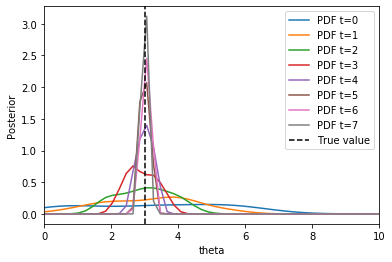

In [5]:
plot(history1)

We observe differences compared to the non-adaptive setting. In particular, the densitities tend to be narrower around the true parameter $\theta=3$. In addition, despite, the better convergence, the required number of samples in total is lower, as not so much time was wasted trying to match an uninformative summary statistic:

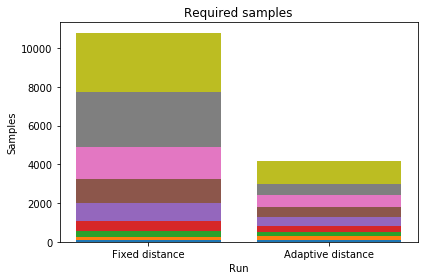

In [6]:
pyabc.visualization.plot_sample_numbers([history0, history1], ["Fixed distance", "Adaptive distance"])

In detail, the adaptive distance feature works as follows: In each iteration of the ABCSMC run, after having obtained the desired number of accepted particles (and once at the beginning using a sample from the prior), the method ``DistanceFunction.update()`` is called. It is given a set of summary statistics which can be used to e.g. compute weights for the distance measure in the next iteration. In order to avoid bias, via ``DistanceFunction.configure_sampler()``, the distance function can tell the sampler to not only record accepted particles, but all that were generated during the sampling process.
So, when you want to define your own adaptive distance function, you will typically only need to overwrite these two methods. For implementation details and an example of how this can look in practice, please inspect the code of ``AdaptivePNormDistance``.

## Make it robust

A problem with the previous adaptive distance occurs when the weights do not work properly. E.g., there could be large weights assigned to rather non-informative statistics, if these vary comparably little. Let us have a look at an example:

In [7]:
import scipy
import tempfile
import os
import matplotlib.pyplot as pyplot
import pyabc.visualization
import logging


# for debugging
df_logger = logging.getLogger('Distance')
df_logger.setLevel(logging.DEBUG)

# model definition
def model(p):
    return {'ss1': p['theta'] + 1 + 1 * scipy.randn(),
            'ss2': 2 + 0.01 * scipy.randn()}

# true model parameter
theta_true = 3

# observed summary statistics
observation = {'ss1': theta_true + 1, 'ss2': 5}

# prior distribution
prior = pyabc.Distribution(theta=pyabc.RV('uniform', 0, 10))

# database
db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")


# plotting

def plot(history):
    fig, ax = pyplot.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=10,
                                       x='theta', ax=ax,
                                       label="PDF t={}".format(t))
    ax.axvline(theta_true, color='k', linestyle='dashed', label="True value")
    ax.legend()

Essentially, we changed the variances of the two summary statistics, and in addition we shifted the observed value `ss2` to 5, which can be interpreted as a measurement error. Now the problem is that this value is highly unlikely to sample from under the model, and when using adaptive weights, this statistic might due to the small variance be assigned a high weight, worsening the problem.

INFO:History:Start <ABCSMC(id=41, start_time=2019-09-28 19:42:18.732058, end_time=None)>
INFO:Epsilon:initial epsilon is 4.1108335102245315
INFO:ABC:t:0 eps:4.1108335102245315
INFO:ABC:t:1 eps:3.337113636658734
INFO:ABC:t:2 eps:3.077333339418514
INFO:ABC:t:3 eps:3.026910707817304
INFO:ABC:t:4 eps:3.00736896223792
INFO:ABC:t:5 eps:2.999857548490543
INFO:ABC:t:6 eps:2.995068289058439
INFO:ABC:t:7 eps:2.989633836874828
INFO:History:Done <ABCSMC(id=41, start_time=2019-09-28 19:42:18.732058, end_time=2019-09-28 19:42:37.902195)>


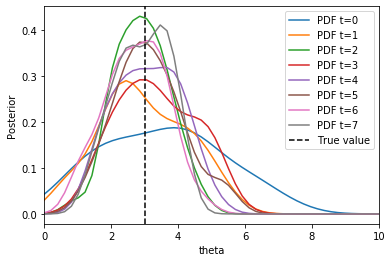

In [8]:
distance = pyabc.PNormDistance(p=2)

abc = pyabc.ABCSMC(model, prior, distance)
abc.new(db_path, observation)
history0 = abc.run(minimum_epsilon=.001, max_nr_populations=8)

plot(history0)

INFO:History:Start <ABCSMC(id=42, start_time=2019-09-28 19:42:38.411661, end_time=None)>
DEBUG:Distance:updated weights[0] = {'ss1': 0.005488852117710042, 'ss2': 1.99451114788229}
INFO:Epsilon:initial epsilon is 5.98701448016224
INFO:ABC:t:0 eps:5.98701448016224
DEBUG:Distance:updated weights[1] = {'ss1': 0.0069641332893576186, 'ss2': 1.9930358667106423}
INFO:ABC:t:1 eps:5.9691590393792575
DEBUG:Distance:updated weights[2] = {'ss1': 0.007204855410391569, 'ss2': 1.9927951445896084}
INFO:ABC:t:2 eps:5.958898137059743
DEBUG:Distance:updated weights[3] = {'ss1': 0.007182377992120522, 'ss2': 1.9928176220078795}
INFO:ABC:t:3 eps:5.950834905400708
DEBUG:Distance:updated weights[4] = {'ss1': 0.007229149429707428, 'ss2': 1.9927708505702928}
INFO:ABC:t:4 eps:5.944124378122915
DEBUG:Distance:updated weights[5] = {'ss1': 0.007112838816515267, 'ss2': 1.9928871611834846}
INFO:ABC:t:5 eps:5.93862416977744
DEBUG:Distance:updated weights[6] = {'ss1': 0.006927085236486322, 'ss2': 1.9930729147635138}
INF

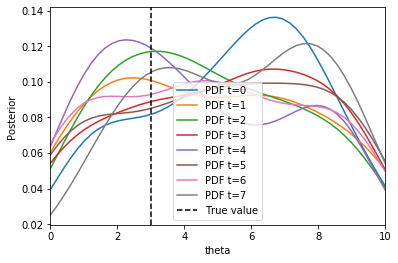

In [9]:
distance_adaptive = pyabc.AdaptivePNormDistance(p=2)

abc = pyabc.ABCSMC(
    model, prior, distance_adaptive,
    acceptor = pyabc.acceptor.accept_use_complete_history)
abc.new(db_path, observation)
history1 = abc.run(minimum_epsilon=.001, max_nr_populations=8)

plot(history1)

These results are as expected: The adaptive weights make the situation much worse. Our solution is to in addition to the in-sample variance also take the bias of the samples to the observed data into account, using e.g. the `root_mean_square_deviation` as scale function.

INFO:History:Start <ABCSMC(id=45, start_time=2019-09-28 19:43:38.617555, end_time=None)>
DEBUG:Distance:updated weights[0] = {'ss1': 0.9046416564338985, 'ss2': 1.0953583435661014}
INFO:Epsilon:initial epsilon is 4.15455378910939
INFO:ABC:t:0 eps:4.15455378910939
DEBUG:Distance:updated weights[1] = {'ss1': 0.9583973092605785, 'ss2': 1.0416026907394214}
INFO:ABC:t:1 eps:3.4783578915157403
DEBUG:Distance:updated weights[2] = {'ss1': 1.130183399807779, 'ss2': 0.8698166001922207}
INFO:ABC:t:2 eps:2.728733895089083
DEBUG:Distance:updated weights[3] = {'ss1': 1.2826595123572366, 'ss2': 0.7173404876427634}
INFO:ABC:t:3 eps:2.1989636104609276
DEBUG:Distance:updated weights[4] = {'ss1': 1.3932269472676806, 'ss2': 0.6067730527323195}
INFO:ABC:t:4 eps:1.8441360395579154
DEBUG:Distance:updated weights[5] = {'ss1': 1.3426275759370065, 'ss2': 0.6573724240629933}
INFO:ABC:t:5 eps:1.9790387106193557
DEBUG:Distance:updated weights[6] = {'ss1': 1.358398425937905, 'ss2': 0.6416015740620951}
INFO:ABC:t:6 e

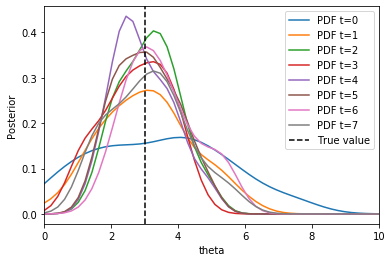

In [10]:
distance_adaptive = pyabc.AdaptivePNormDistance(p=2, scale_function=pyabc.distance.root_mean_square_deviation)

abc = pyabc.ABCSMC(
    model, prior, distance_adaptive,
    acceptor = pyabc.acceptor.accept_use_complete_history)
abc.new(db_path, observation)
history2 = abc.run(minimum_epsilon=.001, max_nr_populations=8)

plot(history2)

In this setting, the accuracy and sample numbers are rougly back to the non-weighted case. Applying this method to the first model shows that it is also applicable there, though potentially slightly less efficient. This demonstrates that this method is more robust in taking model error into account, which in practice can easily occur.

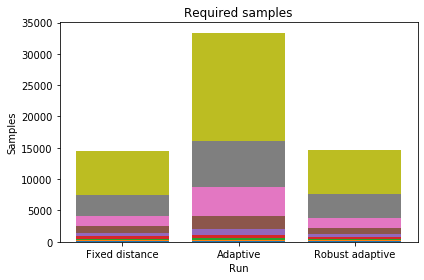

In [11]:
pyabc.visualization.plot_sample_numbers([history0, history1, history2], ["Fixed distance", "Adaptive", "Robust adaptive"])

## Weighting diverse data with multiplicities

The problem setting we consider now is that we can separate our summary statistics (=data) into subsets which are informative for different parameters, but the sizes of these subsets are not balanced. This happens frequently in practice, e.g. when one has a time series of 100 measurements, compared to a single data point. If these two statistics are informative for different parameters, then the impact of the first kind on the computed distance value can be overly high, and in addition the automatic weighting as introduced by Prangle 2017 may not reduce, or can indeed even worsen, the problem.

Thus, what we want to do is add additional "factors" by which we multiply each data point's weight. These factors take into account the number of summary statistics that are equally informative.

In [12]:
import pyabc
import numpy as np
import scipy as sp
import os
import tempfile
import matplotlib.pyplot as plt
import logging

# for debugging
df_logger = logging.getLogger('Distance')
df_logger.setLevel(logging.INFO)

N0 = 100
N1 = 1

p_true = {'p0': 5, 'p1': 10}

def model(p):
    ss = {}
    s0 = p['p0'] + 2 * sp.randn()
    for j in range(N0):
        ss['p0_' + str(j)] = s0
    s1 = p['p1'] + 0.01 * sp.randn()
    for j in range(N1):
        ss['p1_' + str(j)] = s1
    return ss

prior = pyabc.Distribution(p0=pyabc.RV("uniform", 0, 20),
                           p1=pyabc.RV("uniform", 0, 20))

First, we consider uniform weights of 1:

In [13]:
distance = pyabc.PNormDistance(p=1)

abc = pyabc.ABCSMC(model, prior, distance)

observation = model(p_true)

db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history1 = abc.run(max_nr_populations=10)

INFO:History:Start <ABCSMC(id=46, start_time=2019-09-28 19:44:18.268708, end_time=None)>
INFO:Epsilon:initial epsilon is 788.7222587539696
INFO:ABC:t:0 eps:788.7222587539696
INFO:ABC:t:1 eps:300.0538892026867
INFO:ABC:t:2 eps:138.45983833809518
INFO:ABC:t:3 eps:66.50946901577676
INFO:ABC:t:4 eps:40.53857685682945
INFO:ABC:t:5 eps:22.108510236138706
INFO:ABC:t:6 eps:13.621465883941683
INFO:ABC:t:7 eps:9.301454258630265
INFO:ABC:t:8 eps:6.5797324800637425
INFO:ABC:t:9 eps:4.695602975693937
INFO:History:Done <ABCSMC(id=46, start_time=2019-09-28 19:44:18.268708, end_time=2019-09-28 19:46:47.088545)>


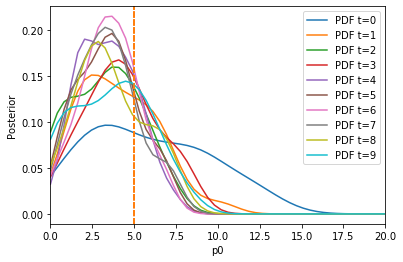

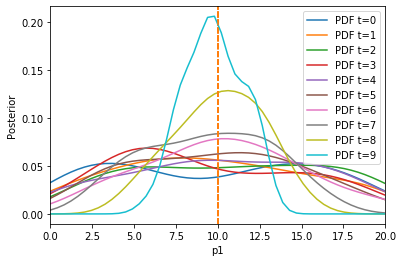

In [14]:
# plotting

def plot(history):
    fig, ax = plt.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=20,
                                        x='p0', ax=ax,
                                        label="PDF t={}".format(t),
                                        refval=p_true)
    ax.legend()

    fig, ax = plt.subplots()
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        pyabc.visualization.plot_kde_1d(df, w, xmin=0, xmax=20,
                                        x='p1', ax=ax,
                                        label="PDF t={}".format(t),
                                        refval=p_true)
    ax.legend()
    
plot(history1)

Next, we use adaptive distances but no factors:

INFO:History:Start <ABCSMC(id=50, start_time=2019-09-28 19:46:49.358585, end_time=None)>
INFO:Epsilon:initial epsilon is 614.3134264448364
INFO:ABC:t:0 eps:614.3134264448364
INFO:ABC:t:1 eps:313.77053587807586
INFO:ABC:t:2 eps:172.38371656185598
INFO:ABC:t:3 eps:77.37010846349652
INFO:ABC:t:4 eps:36.82560922491677
INFO:ABC:t:5 eps:16.588942658803944
INFO:ABC:t:6 eps:8.840377305864171
INFO:ABC:t:7 eps:6.140843106159419
INFO:ABC:t:8 eps:4.2564839281186355
INFO:ABC:t:9 eps:3.440103482603249
INFO:History:Done <ABCSMC(id=50, start_time=2019-09-28 19:46:49.358585, end_time=2019-09-28 19:48:30.922486)>


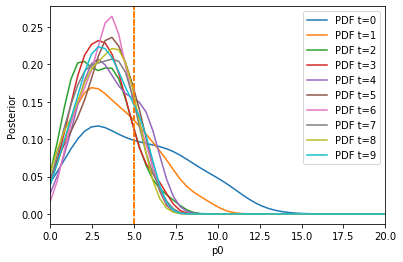

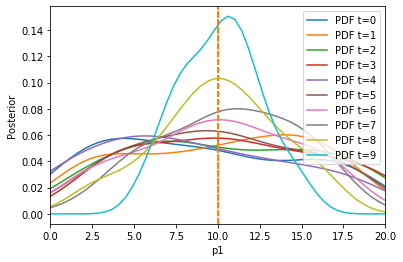

In [15]:
distance = pyabc.AdaptivePNormDistance(p=1, )#factors=factors)

abc = pyabc.ABCSMC(model, prior, distance)

db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history2 = abc.run(max_nr_populations=10)

plot(history2)

Next, we account for the discrepancy in data point counts by using self-defined scaling factors:

INFO:History:Start <ABCSMC(id=51, start_time=2019-09-28 19:48:32.103033, end_time=None)>
INFO:Epsilon:initial epsilon is 10.340204299403318
INFO:ABC:t:0 eps:10.340204299403318
INFO:ABC:t:1 eps:7.138360215767833
INFO:ABC:t:2 eps:5.27073477947616
INFO:ABC:t:3 eps:3.899451751642258
INFO:ABC:t:4 eps:2.71568947816298
INFO:ABC:t:5 eps:1.9487997185494754
INFO:ABC:t:6 eps:1.3420227598029235
INFO:ABC:t:7 eps:0.9367002664770364
INFO:ABC:t:8 eps:0.6160498618350769
INFO:ABC:t:9 eps:0.4154393021881498
INFO:History:Done <ABCSMC(id=51, start_time=2019-09-28 19:48:32.103033, end_time=2019-09-28 19:49:08.948856)>


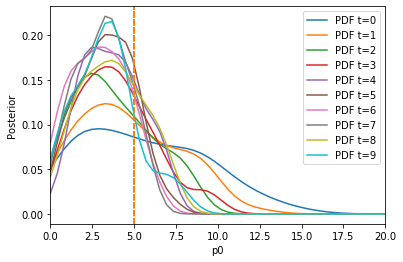

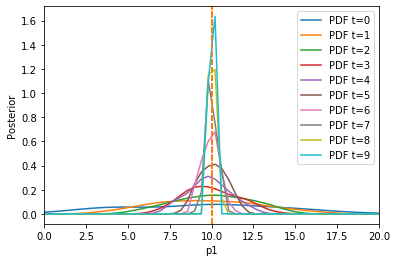

In [16]:
factors = {}
for j in range(N0):
    factors['p0_' + str(j)] = 1/N0
for j in range(N1):
    factors['p1_' + str(j)] = 1/N1
distance = pyabc.PNormDistance(p=1, factors=factors)

abc = pyabc.ABCSMC(model, prior, distance)

db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history3 = abc.run(max_nr_populations=10)

plot(history3)

Next, we consider automatic weighting and factors:

INFO:History:Start <ABCSMC(id=52, start_time=2019-09-28 19:49:10.060701, end_time=None)>
INFO:Epsilon:initial epsilon is 12.009548286929864
INFO:ABC:t:0 eps:12.009548286929864
INFO:ABC:t:1 eps:8.982302769421871
INFO:ABC:t:2 eps:5.391330105487889
INFO:ABC:t:3 eps:3.918517930800373
INFO:ABC:t:4 eps:2.5588341357887456
INFO:ABC:t:5 eps:2.35023638049882
INFO:ABC:t:6 eps:1.868931322551773
INFO:ABC:t:7 eps:1.7289106134816672
INFO:ABC:t:8 eps:1.4087660960127508
INFO:ABC:t:9 eps:1.5258464276210817
INFO:History:Done <ABCSMC(id=52, start_time=2019-09-28 19:49:10.060701, end_time=2019-09-28 19:49:44.780613)>


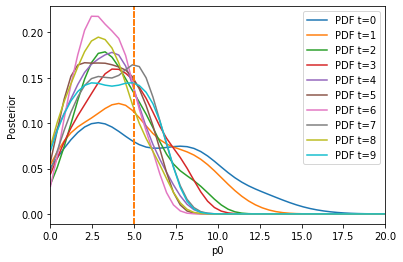

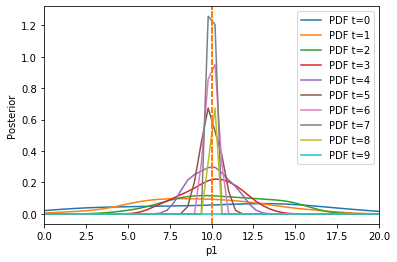

In [17]:
import logging
df_logger = logging.getLogger('Distance')
# df_logger.setLevel(logging.DEBUG)

factors = {}
for j in range(N0):
    factors['p0_' + str(j)] = 1/N0
for j in range(N1):
    factors['p1_' + str(j)] = 1/N1
distance = pyabc.AdaptivePNormDistance(p=1, factors=factors)

abc = pyabc.ABCSMC(model, prior, distance)

db_path = "sqlite:///" + os.path.join(tempfile.gettempdir(), "tmp.db")
abc.new(db_path, observation)
history4 = abc.run(max_nr_populations=10)

plot(history4)

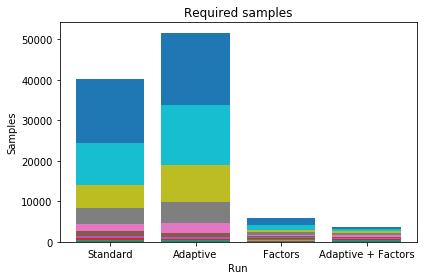

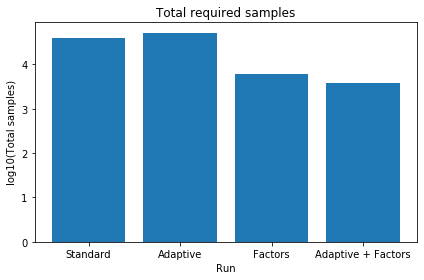

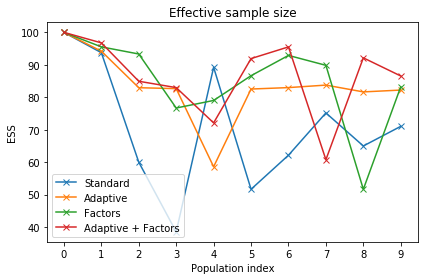

In [18]:
histories = [history1, history2, history3, history4]
labels = ["Standard", "Adaptive", "Factors", "Adaptive + Factors"]

pyabc.visualization.plot_sample_numbers(histories, labels)
pyabc.visualization.plot_total_sample_numbers(histories, labels, yscale='log10')
pyabc.visualization.plot_effective_sample_sizes(histories, labels)